# Import packages

In [613]:
import os
import re
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Load data

In [614]:
nlp = spacy.load("en_core_web_lg")

In [615]:
# Load the environment variables
load_dotenv()

# Get the paths to the data
data_dir = os.getenv("DATA_DIR")
articles_dir = os.path.join(data_dir, "articles")

# Load the main dataset
df = pd.read_csv(f"{data_dir}/article_info_V2.csv", index_col=0, parse_dates=[1])

# Load the external dataset
external_df = pd.read_csv(f"{data_dir}/other-articles.csv", index_col=0, parse_dates=[1], sep=";")

# Cleaning

In [616]:
# Drop unused columns
df.drop(columns=["Author", "Type", "Keywords"], inplace=True)

# Drop rows with empty date values
df.dropna(subset=["Date"], inplace=True)

# Reset the index
df.reset_index(drop=True, inplace=True)

# Remove the url column from the external dataset
external_df.drop(columns=["Url"], inplace=True)

# Merging datasets

In [617]:
# Add the external dataset to the main dataset
df = pd.concat([df, external_df])

# Reset the index
df.reset_index(drop=True, inplace=True)

# Clear the external dataset variable
del external_df

# Remove duplicates

In [618]:
# Count the number of entries before duplicate removal
entries_count = len(df)

# remove duplicate entries by title and date
df.drop_duplicates(subset=["Title", "Date"], keep="first", inplace=True)

# Print the number of deleted entries
print(f"Removed {entries_count - len(df)} duplicate entries.")

# Clear the entries count variable
del entries_count

Removed 4 duplicate entries.


# Parse target

In [619]:
# Define functions to parse target
def clean_string(str):
    # Make the string lowercase
    str = str.lower()
    # Remove all non-alphanumeric characters
    str = re.sub(r"[^\w\s]", "", str)
    # Remove the leading and trailing spaces
    return str.strip()

def parse_tags(str):
    # Split the string on each comma
    raw_list = str.split(",")
    # Clean every string in the list
    return list(map(clean_string, raw_list))

In [620]:
# Convert the raw string values of the Tags column to lists of strings
df["Tags"] = df["Tags"].apply(parse_tags)

In [621]:
# Clear the cleaning and parsing functions
del clean_string, parse_tags

# Load articles

In [622]:
# Article loading function
def load_article(title):
    # Create filename from title
    file_name = f"{title}.txt"
    # Get the path of the article
    file_path = os.path.join(articles_dir, file_name)
    try:
        # Attempt to read the article
        file = open(file_path, "r", encoding="utf-8")
    except:
        # If the article could not be read, return None
        return None
    # Read the contents of the article
    contents = file.read()
    # Close the file
    file.close()
    # Return the contents of the article
    return contents

In [623]:
# Load the articles
df["Contents"] = df["Title"].apply(load_article)

# Clear the article loading function
del load_article

In [624]:
# Count the number of entries in the dataframe
entries_count = len(df)

# Remove rows without article contents
df.dropna(subset=["Contents"], inplace=True)

# Reset the index
df.reset_index(drop=True, inplace=True)

# Print the number of deleted entries
print(f"Removed {entries_count - len(df)} entries without article contents.")

# Clear the entries count variable
del entries_count

Removed 292 entries without article contents.


# Create categories from tags

In [625]:
unique_tags = []
for tag_list in df["Tags"]:
    for tag in tag_list:
        if tag not in unique_tags:
            unique_tags.append(tag)

In [626]:
# Load the custom categories dataset
custom_categories = pd.read_csv(f"{data_dir}/custom-categories.csv", sep=";")

# After receiving feedback from SKC, we decided to drop the following categories:
custom_categories.drop(columns=["People", "Places", "Criminal groups"], inplace=True)

# Define a function to parse the custom categories into a list of strings
def load_category(name):
    try:
        return custom_categories[name].dropna().tolist()
    except:
        return None

In [627]:
# Initiate the category dictionary
categories = {}

# Iterate over these custom_categories columns
for category_name in custom_categories.columns:
    # Load the category
    categories[category_name] = load_category(category_name)

In [628]:
# Create a new column for the category
df["Category"] = ""

# Iterate over the dataframe
for index, row in df.iterrows():
    # Get the tags of the current row
    tag_list = row["Tags"]
    # Create a dictionary for the counters of the categories for this article
    counters = {}
    # Iterate over every tag in the tag list
    for tag in tag_list:
        # Iterate over the categories
        for category_name in categories:
            # Get the current category
            category = categories[category_name]
            # Check if the tag is in the category list
            if tag in category:
                # If it is, add it to the counters dictionary
                if category_name not in counters:
                    counters[category_name] = 1
                else:
                    counters[category_name] += 1    
    # Get the category with the highest counter and assign it to the row
    if len(counters) == 0:
        row["Category"] = "Other"
    else:
        row["Category"] = max(counters, key=counters.get)

In [629]:
categories = df["Category"].value_counts()

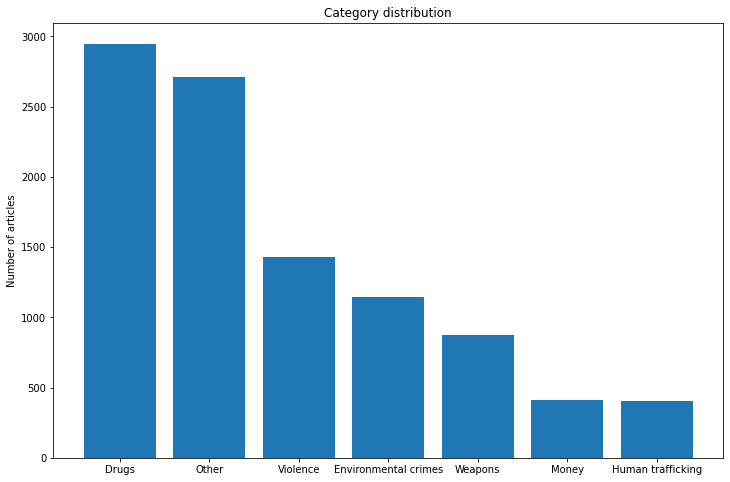

In [630]:
plt.figure(figsize=(12, 8))
plt.title("Category distribution")
plt.ylabel("Number of articles")
plt.bar(categories.index, categories.values)
plt.show()

In [631]:
df.head(10)

,Date,Title,Tags,Contents,Category
0,2021-12-14 19:13:22+00:00,Did Anti-Drug Crusade Lead to Haiti President'...,"[contraband, zetas, haiti, cocaine, el salvado...",An explosive new report suggests that the high...,Drugs
1,2021-12-14 14:18:15+00:00,Colombian Prosecutors Dismiss Memo Fantasma Li...,"[invisibles, while scrambling to save himself ...",Prosecutors in Colombia have dismissed a crimi...,Other
2,2021-12-13 19:36:23+00:00,Could US Anti-Violence Models Work in Latin Am...,"[chepe luna, mexico, security policy, while sc...",Efforts to reduce gang violence are often thou...,Other
3,2021-12-13 14:27:23+00:00,How Mexican Cartels Settled in Canada,"[brazil, el paisa, guatemala personalities, me...",The story of the Mexican cartels and their inf...,Drugs
4,2021-12-10 19:11:18+00:00,Haiti Gangs Profit from Targeting Religious Gr...,"[nicaragua, oficina de envigado, caribbean, lo...",Religious groups are among the final instituti...,Other
5,2021-12-10 13:29:09+00:00,Peru's Anti-Corruption Crusade Grows Weaker,"[peru, brazil, colombia groups, sebastian pais...",Authorities in Peru have dismantled a complex ...,Other
6,2021-12-09 13:26:52+00:00,"US Blacklists El Salvador Officials, Bolsterin...","[el chayo, amigos dos amigos, el salvador, usa...",In what appears to be a shot at El Salvador Pr...,Other
7,2021-12-08 19:30:00+00:00,"Laborers from Mexico, Central America Exploite...","[el salvador groups, contraband, mexico, valen...",A transnational labor trafficking network brou...,Drugs
8,2021-12-08 13:30:04+00:00,FARC Dissidents First to be Charged Under New ...,"[farc, environmental crime, el barney, exfarc ...",Colombia is rolling out a new strategy to figh...,Environmental crimes
9,2021-12-07 22:30:00+00:00,Daring Prison Break Shows Ongoing Influence of...,"[brazil, fuel theft, mexico, pccbolivia, domin...",Oil theft gangs continue to be a dominant crim...,Environmental crimes


In [715]:
px = df.loc[df['Category'].isin(["Money"])]
px

,Date,Title,Tags,Contents,Category
32,2021-11-11 15:33:22+00:00,Extradition of Mexico Governor Highlights Catt...,"[chepe luna, el chayo, mexico, usmexico border...","The disgraced former governor of Chihuahua, Cé...",Money
58,2021-10-22 11:24:13+00:00,Indictment of Saab Partners Details Vast Venez...,"[mexico, perfiles geográficos, money launderin...",Business partners of Álex Saab – an accused mo...,Money
103,2021-09-13 18:04:40+00:00,Is Dominican Republic Making Gains in Anti-Cor...,"[caribbean, while scrambling to save himself f...",The dismantling of a drug trafficking and mone...,Money
104,2021-09-13 13:25:34+00:00,Costa Rica Struggles to Profit from Sale of Na...,"[brazil, alex saab, argentina, don berna, el s...","In Costa Rica, the seizure of narco-assets pre...",Money
110,2021-09-08 02:43:45+00:00,"Álex Saab, Venezuela’s Keeper of Financial Sec...","[brazil, belize, z42, money laundering, venezu...",A court in Cabo Verde has approved the extradi...,Money
...,...,...,...,...,...
9872,2010-11-01 20:28:19+00:00,Top FARC Leader 'Mono Jojoy' Dead,"[did one last tour of his prime refuge, mono j...",In what President Juan Manuel Santos called th...,Money
9879,2010-11-01 19:12:03+00:00,Bolivia Cocaine Represents Up to 3 pc of GDP,"[gentil duarte, peru personalities, counterfei...",Echoing a statistic published three months ago...,Money
9884,2010-11-01 12:40:35+00:00,37 Dead from Guerrilla Attacks in September,"[brazil, chile, eln, mono jojoy, counterfeit, ...",September has been one of the bloodiest months...,Money
9892,2010-11-01 00:55:36+00:00,5 Peasants Killed in Border Area,"[pgc, counterfeit, el ingeniero tijuana, knigh...",Five “peasant farmers” were killed and two mor...,Money


In [730]:
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)

doc = nlp(df['Contents'][(0)])

# Write multiple patterns to find if an article contains cocaine etc.
pattern = [
# drugs
[{"LEMMA": "drug"},{"POS": "NOUN", "OP": "?"}],
[{"POS": "ADJ", "OP": "?"},{"TEXT": "cocaine"},{"POS": "NOUN", "OP": "?"}],
# environmental crimes
[{"LEMMA": "deforestation"}],
[{"LEMMA": "environment"}],
[{"LEMMA": "illegal"},{"POS": "NOUN", "OP": "?"}],
# violence
[{"LEMMA": "violence"}],
[{"TEXT": "violent"},{"POS": "NOUN", "OP": "?"}],
[{"LEMMA": "kidnap"}],
[{"POS": "NOUN", "OP": "?"},{"LEMMA": "threat"}],
[{"LEMMA": "murder"}],
[{"LEMMA": "shoot"}],
[{"TEXT": "death"}],
[{"TEXT": "assassin"}],
[{"LEMMA": "robbery"}],
[{"TEXT": "hitman"}],
[{"TEXT": "dead"}],
[{"TEXT": "execution"}],
[{"POS": "NOUN", "OP": "?"},{"LEMMA": "killing"}],
# weapons
[{"POS": "ADJ", "OP": "?"},{"LEMMA": "weapon"},{"POS": "NOUN", "OP": "?"}],
[{"POS": "VERB", "OP": "?"},{"LEMMA": "weapon"}],
[{"LEMMA": "arms"},{"POS": "NOUN", "OP": "?"}],
[{"LEMMA": "gun"},{"POS": "NOUN", "OP": "?"}],
[{"TEXT": "AK-47"}],
[{"LEMMA": "explosive"}],
[{"POS": "NOUN", "OP": "?"},{"LEMMA": "rifle"}],
# trafficking
[{"POS": "ADJ", "OP": "?"},{"LEMMA": "human"},{"POS": "NOUN", "OP": "?"}],
[{"POS": "NOUN", "OP":"?"},{"LEMMA": "trafficking"}],
[{"TEXT": "traffickers"}],
# money
[{"POS": "ADJ", "OP": "?"},{"LEMMA": "laundering"},{"POS": "NOUN", "OP": "?"}],
[{"TEXT": "fraudulent"}],
[{"LEMMA": "fraude"}],
[{"LEMMA": "money"}],
[{"LEMMA": "corruption"}],
#other
]

# Add the pattern to the matcher and apply the matcher to the doc
matcher.add("DETERMINE CATEGORY", [pattern][0])
matches = matcher(doc)
print("Total matches found:", len(matches))

# Iterate over the matches and print the span text
for match_id, start, end in matches:
    print("Match found:", doc[start:end].text)

Total matches found: 56
Match found: explosive
Match found: drug
Match found: drug trafficking
Match found: trafficking
Match found: killing
Match found: shot
Match found: dead
Match found: drug
Match found: drug officials
Match found: drug
Match found: drug trafficking
Match found: trafficking
Match found: corruption
Match found: cocaine
Match found: drug
Match found: drug trafficking
Match found: trafficking
Match found: murder
Match found: drug
Match found: drug trafficking
Match found: trafficking
Match found: drug
Match found: drug flights
Match found: arms trafficking
Match found: trafficking
Match found: drug
Match found: drug crusade
Match found: regional cocaine
Match found: regional cocaine trade
Match found: cocaine
Match found: cocaine trade
Match found: drug
Match found: drug traffickers
Match found: traffickers
Match found: drug
Match found: drug trafficking
Match found: trafficking
Match found: drug
Match found: drug money
Match found: money
Match found: cocaine
Match fo

In [728]:
doc

Panamanian authorities announced the construction of the fifth air station in the Veraguas province, along the Belén river, some 110 miles to the west of the capital city, the EFE agency reported . The government’s top anti-drug official, José Raúl Mulino, also said that authorities in that country had captured 71 tons of cocaine between July 2009 and August 2010, what he called “industrial-sized” quantities. The government hopes, he said, to have a dozen air and navel bases to control the passage of drugs through their waters, airspace and land.

In [729]:
" ".join([token.lemma_ for token in doc])

'panamanian authority announce the construction of the fifth air station in the Veraguas province , along the Belén river , some 110 mile to the west of the capital city , the EFE agency report . the government ’s top anti - drug official , José Raúl Mulino , also say that authority in that country have capture 71 ton of cocaine between July 2009 and August 2010 , what he call " industrial - sized " quantity . the government hope , he say , to have a dozen air and navel basis to control the passage of drug through their water , airspace and land .'